In [1]:
!pip install -q statsmodels

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from joblib import dump, load

from ta import add_all_ta_features

from utils import check_data_gaps, preprocess_time_series
from feature_generation import Preprocess, create_features, get_feature_names
import warnings
warnings.filterwarnings("error")
jtplot.style()

In [8]:
data = pd.read_csv('data/btc_2021-04-01_2021-04-25_5m.csv', index_col=['date'], parse_dates=['date'])
data = (data
        .resample(rule='5min')
        .asfreq()
        .interpolate(method='time', limit=None))

np.seterr(invalid='ignore')
warnings.filterwarnings("default")
data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
print(f'Data shape: {data.shape}')

# cols_to_scale = data.columns[(data.mean(axis=0) > 100) & (data.min(axis=0) > 0)]
cols_to_scale = load('saved_models/column_scale_v1.joblib')
for col in cols_to_scale:
    data[col] = np.log(data[col] + 1)
    
X_data = data.reset_index(drop=True)
np.seterr(invalid='raise')
warnings.filterwarnings("error")

X_features, Y, weights = create_features(data_raw=X_data,
                                         fs=1,
                                         segment_window=12*24,
                                         partitioning=True,
                                         window_length=12*24,
                                         label_length=12*4,
                                         stride= 12*4,
                                         subsample_factor= 1,
                                         binary_delta_labels=True,
                                         binary_delta_value='Close')
# weights = len(weights) * weights / np.sum(weights)
if np.where(np.isnan(X_features))[0].shape[0] > 0:
    print('NAN Values')
    
feature_names = get_feature_names(raw_names=X_data.columns)
X_features = pd.DataFrame(X_features, columns=feature_names)
print(f'Data shape: {X_features.shape}, labels shape: {Y.shape}, feature names: {len(feature_names)}')

/usr/local/lib/python3.6/dist-packages/ta/trend.py:936: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/usr/local/lib/python3.6/dist-packages/ta/trend.py:937: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Data shape: (7096, 88)
Data shape: (141, 22584), labels shape: (141,), feature names: 22584


In [16]:
warnings.filterwarnings("default")
FEATURES_PATH = 'saved_models/feature_list_v9.joblib'
MODEL_PATH = 'saved_models/classification_model_BTC_v9.joblib'

feature_list = load(FEATURES_PATH)
model = load(MODEL_PATH)
X_features = X_features[feature_list]
data_probs = model.predict_proba(X_features)[:, 1]

<AxesSubplot:title={'center':'Feature Importance'}>

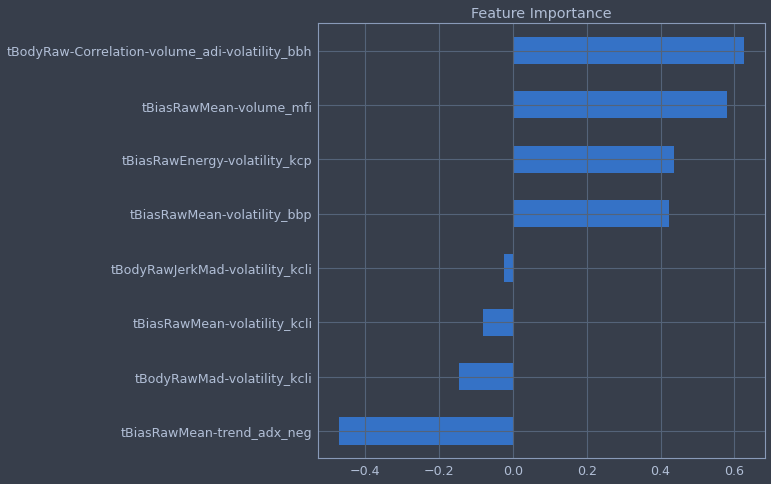

In [17]:
selected_features = X_features.columns
selected_features = selected_features[model[0].get_support()]
selected_data = model[1].transform(X_features[selected_features].values)
selected_data = pd.DataFrame(selected_data, columns=selected_features)
selected_features = selected_features[model[2].get_support()]
selected_data = selected_data[selected_features]
feature_importance = model[-1].coef_[0] * selected_data.std(axis=0)
feature_importance = feature_importance[feature_importance != 0.0]
feature_importance.sort_values(inplace=True)
feature_importance.plot(kind='barh', title='Feature Importance', figsize=(8,8))

In [18]:
import functools
import operator
import datetime

def avg_datetime(series):
    dt_min = series.min().values
    deltas = [x-dt_min for x in series.values.astype('datetime64[ns]')]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

preprocessor = Preprocess(fs=1, seg_window=12*24)
_, dates, _ = preprocessor.partition_time_series(signal=pd.DataFrame(data.index),
                                           window_length=12*24,
                                           label_length=12*4,
                                           stride=12*4,
                                           subsample_factor= 1,
                                           binary_delta_labels= False,
                                           binary_delta_value= 'Close')

plot_ticks = np.array([avg_datetime(i) for i in dates]).flatten()

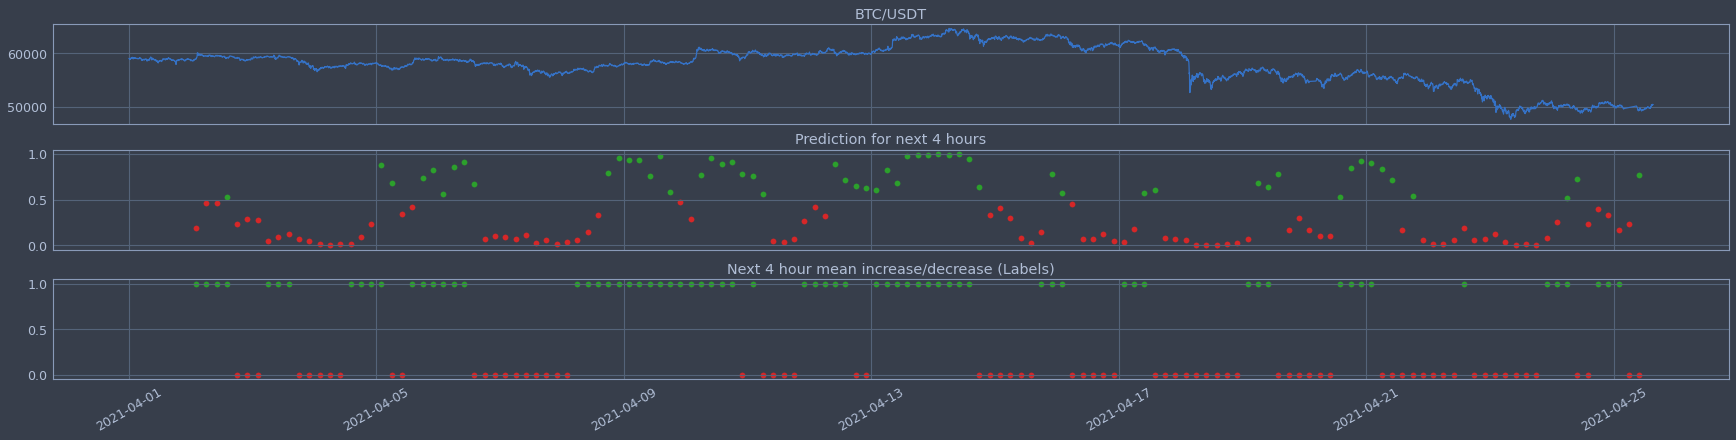

In [20]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(3, 1, figsize=(24,6), constrained_layout=True, sharex=True)
ax[0].plot(np.exp(data['Close'])-1)
ax[0].set_title('BTC/USDT')
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax[1].scatter(plot_ticks[data_probs > 0.5], data_probs[data_probs > 0.5], c='tab:green')
ax[1].scatter(plot_ticks[data_probs < 0.5], data_probs[data_probs < 0.5], c='tab:red')
ax[1].scatter(plot_ticks[data_probs == 0.5], data_probs[data_probs == 0.5], c='tab:grey')
ax[1].set_title('Prediction for next 4 hours')
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax[2].scatter(plot_ticks[Y > 0.5], Y[Y > 0.5], c='tab:green')
ax[2].scatter(plot_ticks[Y < 0.5], Y[Y < 0.5], c='tab:red')
ax[2].set_title('Next 4 hour mean increase/decrease (Labels)')
# ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_tick_params(rotation = 30)
# plt.gca().set_xbound('2021-03-17 12:00:00', '2021-03-18 12:00:00')
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.92      0.90 1.3201661965447382
           1       0.85      0.78      0.81 0.7483840987796402

    accuracy                           0.87 2.0685502953243784
   macro avg       0.87      0.85      0.86 2.0685502953243784
weighted avg       0.87      0.87      0.87 2.0685502953243784



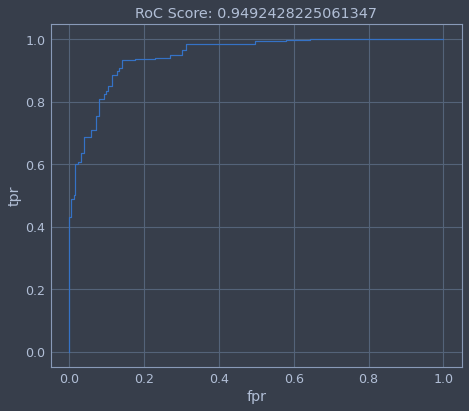

In [21]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

report = classification_report(Y, data_probs > 0.5, sample_weight=weights)
print(report)

roc = roc_auc_score(Y, data_probs, sample_weight=weights)
fpr, tpr, _ = roc_curve(Y, data_probs, sample_weight=weights)
fig, ax = plt.subplots(1,1, constrained_layout=True)
ax.plot(fpr, tpr)
ax.set_title(f'RoC Score: {roc}')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.show()

In [31]:
warnings.filterwarnings("default")
FEATURES_PATH = 'saved_models/feature_list_v8.joblib'
MODEL_PATH = 'saved_models/classification_model_BTC_v8.joblib'

feature_list = load(FEATURES_PATH)
model = load(MODEL_PATH)
X_features = X_features[feature_list]
data_probs = model.predict_proba(X_features)
data_predictions= model.predict(X_features)

In [32]:
import functools
import operator
import datetime

def avg_datetime(series):
    dt_min = series.min().values
    deltas = [x-dt_min for x in series.values.astype('datetime64[ns]')]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

preprocessor = Preprocess(fs=1, seg_window=12*24)
_, dates = preprocessor.partition_time_series(signal=pd.DataFrame(data.index),
                                           window_length=12*24,
                                           label_length=12*4,
                                           stride=12*4,
                                           subsample_factor= 1,
                                           binary_delta_labels= False,
                                           binary_delta_value= 'Close')

plot_ticks = np.array([avg_datetime(i) for i in dates]).flatten()

In [33]:
Y = y[1:] - y[:-1] + 1

In [34]:
data_labels = Y

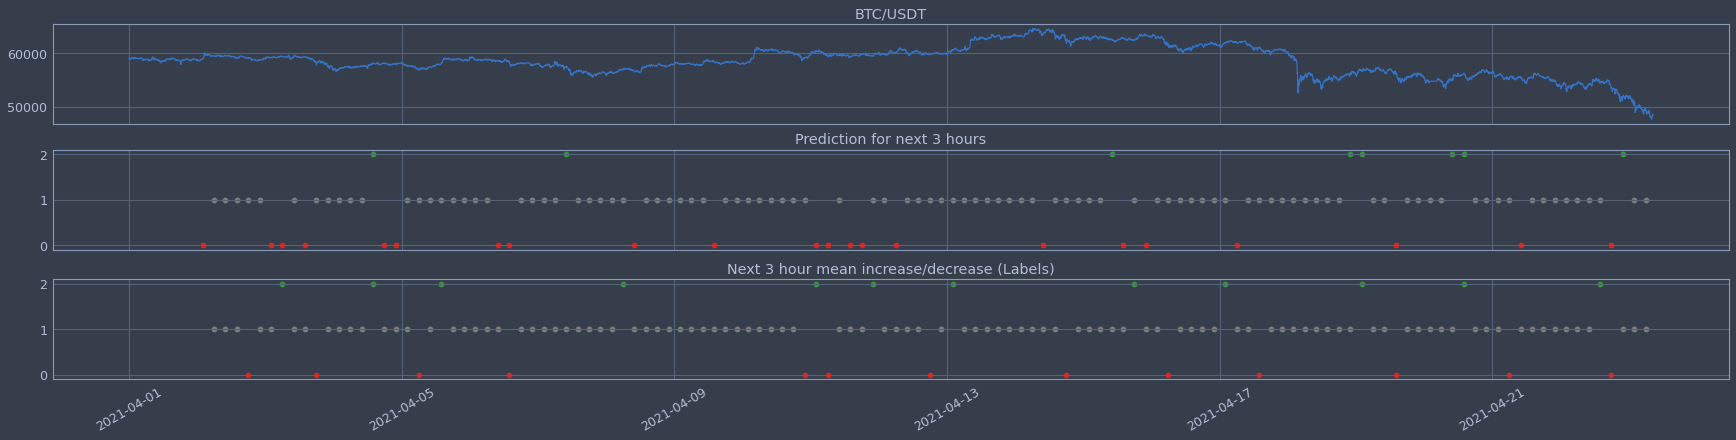

In [35]:
jtplot.style()
data_probs_class = np.argmax(data_probs.reshape(-1, 3), axis=1)
fig, ax = plt.subplots(3, 1, figsize=(24,6), constrained_layout=True, sharex=True)
ax[0].plot(np.exp(data['Close'])-1)
ax[0].set_title('BTC/USDT')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 2], data_probs_class[data_probs_class == 2], c='tab:green')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 0], data_probs_class[data_probs_class == 0], c='tab:red')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 1], data_probs_class[data_probs_class == 1], c='tab:grey')
ax[1].set_title('Prediction for next 3 hours')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 2], data_labels[data_labels == 2], c='tab:green')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 0], data_labels[data_labels == 0], c='tab:red')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 1], data_labels[data_labels == 1], c='tab:gray')
ax[2].set_title('Next 3 hour mean increase/decrease (Labels)')
plt.gca().xaxis.set_tick_params(rotation = 30)
# plt.gca().set_xbound('2021-02-21', '2021-03-07')
plt.show()

In [36]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

report = classification_report(data_labels, data_predictions[1:])
print(report)

              precision    recall  f1-score   support

           0       0.19      0.31      0.24        13
           1       0.84      0.80      0.82       102
           2       0.38      0.25      0.30        12

    accuracy                           0.70       127
   macro avg       0.47      0.45      0.45       127
weighted avg       0.73      0.70      0.71       127

